# Classification Using CNN from PyTorch
## Goal:
Build a deep learning model to classify images using a CNN model with PyTorch and experiment with ways on improving accuracy.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import tarfile

In [497]:
current_folder = '/Users/doncheung/Desktop/AMSI/Assignment 2' # modify this according to your local file location containing the stl10_binary.tar.gz file

device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else 
    "cpu"
)

# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


# 0. (Optional) Extract binary data from the ".tar.gz" file

If the user has not extracted the binary files from before, than the code below can be used to do so.

In [ ]:
extract_this = f'{current_folder}/stl10_binary.tar.gz' # have the stl10_binary.tar.gz file saved in the same location as this notebook
tar = tarfile.open(extract_this, "r:gz")
tar.extractall()
tar.close()

# 1. Loading the binary files

Instead of using ".png" files, we directly use the binary files as our data with the PyTorch CNN module.

In [498]:
def load_split(split): # train, test
    X_path = f'{path}{split}_X.bin'
    y_path = f'{path}{split}_y.bin'
    X = np.fromfile(X_path, dtype=np.uint8).reshape((-1, 3, 96, 96)) # image data type needs to all be in np.uint8
    X = np.moveaxis(X, 2, 3) # convert column-major to row-major
    y = np.fromfile(y_path, dtype=np.uint8) 
    y = y - 1 # convert range [1,10] to [0,9]
    print('Loaded split "{}" with sizes: Images {}, labels {}'.format(split, X.shape, y.shape))
    return X, y

path = f'{current_folder}/stl10_binary/'
full_train_X, full_train_y = load_split('train')
full_test_X, full_test_y = load_split('test')

Loaded split "train" with sizes: Images (5000, 3, 96, 96), labels (5000,)
Loaded split "test" with sizes: Images (8000, 3, 96, 96), labels (8000,)


# 2. View class names and images as a sanity check

In [474]:
with open(path+'class_names.txt') as f:
    full_class_names = f.readlines()

full_class_names = [name.strip() for name in full_class_names]

print('The classes in the dataset are: ')
print(list(enumerate(full_class_names)))

The classes in the dataset are: 
[(0, 'airplane'), (1, 'bird'), (2, 'car'), (3, 'cat'), (4, 'deer'), (5, 'dog'), (6, 'horse'), (7, 'monkey'), (8, 'ship'), (9, 'truck')]


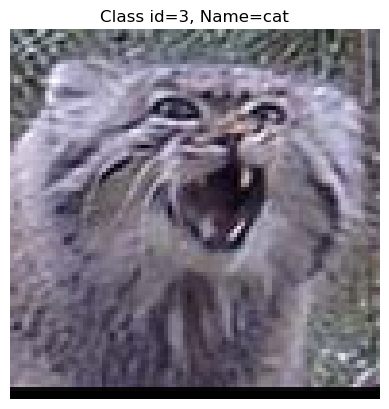

In [393]:
def visualize_sample(X, y, class_names):
    X_vis = np.moveaxis(X, 0, 2) # convert Channel, Width, Height order to W,H,C
    plt.figure()
    plt.imshow(X_vis, interpolation='nearest')
    plt.axis('off')
    plt.title('Class id={}, Name={}'.format(y, class_names[y]))

i = np.random.randint(0, full_train_X.shape[0]-1) # choose a random image to check
visualize_sample(full_train_X[i],
                 full_train_y[i],
                 full_class_names)

# 3. Define function for data augmentation

We apply the following augmentations to the training dataset:

- random horizontal flip with 50% probability

- rotation of each picture by up to 10 degrees clockwise/anticlockwise

In [ ]:
from torchvision import transforms

train_transforms = transforms.Compose([     # applying data augmentation as a regulariser
    transforms.RandomHorizontalFlip(p=0.5), # random horizontal flip at a 50% probability
    transforms.RandomRotation(10)           # random rotatation by up to 10 degrees clockwise/anticlockwise
])                                          # the user can apply additional transforms      


class ArrayDataset(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        self.transform = transform
        
    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        image = self.X[index]
        label = self.y[index]

        if self.transform: # only apply augmentation for the training data
            image = self.transform(image)
            
        return image, label

# 4. Design the CNN architecture

In [396]:
class Sine(nn.Module):
    def __init__(self, w0: float = 1.0):
        """Sine activation function with w0 scaling support.

        Example:
            >>> w = torch.tensor([3.14, 1.57])
            >>> Sine(w0=1)(w)
            torch.Tensor([0, 1])

        :param w0: w0 in the activation step `act(x; w0) = sin(w0 * x)`.
            defaults to 1.0
        :type w0: float, optional
        """
        super(Sine, self).__init__()
        self.w0 = w0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._check_input(x)
        return torch.sin(self.w0 * x)

    @staticmethod
    def _check_input(x):
        if not isinstance(x, torch.Tensor):
            raise TypeError(
                'input to forward() must be torch.xTensor')

In [590]:
class CNN(nn.Module):
    def __init__(self, num_out_classes, activation_function_type = "relu"): # relu, sine, etc.
    
        super(CNN, self).__init__()
        
        if activation_function_type == "sine":
            self.activation = Sine(1.0)
        elif activation_function_type == "relu":
            self.activation = nn.ReLU()
        elif activation_function_type == "gelu":
            self.activation = nn.GELU()
        elif activation_function_type == "tanh":
            self.activation = nn.Tanh()

        # input: 3x96x96 -> output: 
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=32,
                               kernel_size=3,
                               padding=1,
                               stride=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=32*2,
                               kernel_size=3,
                               padding=1,
                               stride = 1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=32*2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32*2,
                               out_channels=32*4,
                               kernel_size=3,
                               padding=1,
                               stride = 1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32*4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(32 * 4 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_out_classes)

        self.dropout_half = nn.Dropout(p=0.5)
        self.dropout_quarter = nn.Dropout(p=0.25)

    
    def forward(self, x):
        # bring input to [-1,1] range
        # x = x.to(torch.float32) / 128.0 - 1.0
        x = x.float()/ 128.0 - 1.0
        # sequence of operations: convolution --> batch normalization --> non-linearity --> pooling
        x = self.pool1(self.activation(self.bn1(self.conv1(x))))
        x = self.pool2(self.activation(self.bn2(self.conv2(x))))
        x = self.pool3(self.activation(self.bn3(self.conv3(x))))  

        x = torch.flatten(x, 1)
        x = self.fc1(x) 
        x = self.dropout_half(self.activation(x))  
        x = self.fc2(x)
        return x

Review the summary of the CNN archictecture. This includes the output shapes and parameters involved for each layer.

In [591]:
from torchvision import models
from pytorch_model_summary import summary

vgg = CNN(10)
print(summary(vgg, torch.zeros(1, 3, 96, 96)))

------------------------------------------------------------------------
      Layer (type)         Output Shape         Param #     Tr. Param #
          Conv2d-1      [1, 32, 96, 96]             864             864
     BatchNorm2d-2      [1, 32, 96, 96]              64              64
            ReLU-3      [1, 32, 96, 96]               0               0
       MaxPool2d-4      [1, 32, 48, 48]               0               0
          Conv2d-5      [1, 64, 48, 48]          18,432          18,432
     BatchNorm2d-6      [1, 64, 48, 48]             128             128
            ReLU-7      [1, 64, 48, 48]               0               0
       MaxPool2d-8      [1, 64, 24, 24]               0               0
          Conv2d-9     [1, 128, 24, 24]          73,728          73,728
    BatchNorm2d-10     [1, 128, 24, 24]             256             256
           ReLU-11     [1, 128, 24, 24]               0               0
      MaxPool2d-12     [1, 128, 12, 12]               0        

# 5. Define function for computing (training) accuracy

In [501]:
def compute_accuracy(data_loader,
                     cnn,
                     split,
                     print_output,
                     device):
  
    cnn.eval() # sets the model into evaluation mode
    total_accuracy = 0
    total_samples = 0

    for i, batch in enumerate(data_loader):
        X_batch, y_batch = batch # get the inputs and labels

        X_batch = X_batch.to(device).float() 
        y_batch = y_batch.to(device)
        
        predictions_batch = cnn(X_batch) # calculate predictions given a batch of samples      
        _, vals = torch.max(predictions_batch, 1) # convert each prediction into a class id
        total_accuracy += (vals == y_batch.type(torch.long)).int().sum() # calculate the amount of predicted class ids matching the ground truth and increment counters
        total_samples += y_batch.shape[0]
        out_accuracy = int(total_accuracy) * 1.0 / total_samples

    if print_output:
        print(f'Accuracy over "{split}" split is {100 * out_accuracy:.4f}%')

    return 100 * out_accuracy

# 6. Define function for the training process

In [ ]:
def train(cnn, loader_train, loader_test, num_epochs, learning_rate = 0.001, track_accuracy = True):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    cnn.to(device) 

    criterion = nn.CrossEntropyLoss() # we use the Cross Entropy Loss function
    optimizer = optim.Adam(cnn.parameters(), lr=0.0001)
    # for ReLU -> no weight_decay 
    # for sine -> weight_decay = 0.00005
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs) # dynamically update learning to prevent overshooting at later epochs
    tr_acc, ts_acc, tr_loss, ts_loss = [], [], [], [] # define lists to record training and testing accuracy at each epoch

    # In each epoch, run the optimizer operation on each batch
    for epoch in range(num_epochs):
        cnn.train() # set the model into training mode

        train_loss = 0.0
        for i, batch in enumerate(loader_train):
            X_batch, y_batch = batch
            # y_batch = y_batch.type(torch.long)
            X_batch = X_batch.to(device)
            y_batch = y_batch.type(torch.long).to(device)

            optimizer.zero_grad() # zero the parameter gradientsle
            predictions_batch = cnn(X_batch) # forward pass
            loss1 = criterion(predictions_batch, y_batch) # calculate loss for the provided predictions and ground truth labels
            train_loss += loss1.item()
            loss1.backward()
            optimizer.step()
       
        cnn.eval() # set to evaluate model to obain test loss at each epoch
        test_loss = 0.0
        with torch.no_grad():
            for i, batch in enumerate(loader_test):
                X_batch, y_batch = batch
                # y_batch = y_batch.type(torch.long)
                X_batch = X_batch.to(device)
                y_batch = y_batch.type(torch.long).to(device)
                predictions_batch = cnn(X_batch)
                loss2 = criterion(predictions_batch, y_batch)
                test_loss += loss2.item()
       
        if track_accuracy: # code for tracking training and testing accuracy at each epoch
            train_accuracy = compute_accuracy(data_loader = loader_train,
                                           cnn = cnn,
                                           split = 'train',
                                           print_output = False,
                                           device = device)
            test_accuracy = compute_accuracy(data_loader = loader_test,
                                           cnn = cnn,
                                           split = 'test',
                                           print_output = False,
                                           device = device)
            tr_acc.append(train_accuracy)
            ts_acc.append(test_accuracy)
            
        train_loss /= len(loader_train)
        test_loss /= len(loader_test)
        tr_loss.append(train_loss)
        ts_loss.append(test_loss)
        print(f'Epoch {epoch+1}/{num_epochs} -> train loss {train_loss:.4f}, test loss = {test_loss:.4f}, train acc {train_accuracy:.4f}, test acc = {test_accuracy:.4f}')
        scheduler.step()

    if track_accuracy: # plotting training and testing accuracy after model has finished training
        plt.figure(figsize=(12,5))

        plt.subplot(1,2,1)
        plt.plot(np.array(tr_acc))
        plt.plot(np.array(ts_acc))
        plt.legend(['train accuracy', 'test accuracy'])
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')

        plt.subplot(1,2,2)
        plt.plot(np.array(tr_loss))
        plt.plot(np.array(ts_loss))
        plt.legend(['train loss', 'test loss'])
        plt.title('Loss over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        plt.show()
        plt.close()

    print('Finished Training')

# 7. Training and testing process for 2 class classification

### 7. a) Split for 2 class classifcation

In [503]:
ID_C1_OLD, ID_C2_OLD = 3, 8 # C1: CAT, C2: SHIP
ID_C1_NEW, ID_C2_NEW = 0, 1

def subsplit_two_classes(X, y, split):
    indices = np.where(np.logical_or(y==ID_C1_OLD, y==ID_C2_OLD))
    X_out = X[indices]
    y_out = y[indices]
    y_out = (y_out == ID_C1_OLD).astype(np.uint8) * ID_C1_NEW + (y_out == ID_C2_OLD).astype(np.uint8) * ID_C2_NEW
    print('Created "{}" subsplit with only 2 classes with sizes: Images {}, labels {}'.format(split, X_out.shape, y_out.shape))
    return X_out, y_out

train_two_classes_X, train_two_classes_y = subsplit_two_classes(full_train_X,
                                                                full_train_y,
                                                                'train')

test_two_classes_X, test_two_classes_y = subsplit_two_classes(full_test_X,
                                                              full_test_y,
                                                              'test')

class_names_two_classes = [full_class_names[i] for i in (ID_C1_OLD, ID_C2_OLD)]

Created "train" subsplit with only 2 classes with sizes: Images (1000, 3, 96, 96), labels (1000,)
Created "test" subsplit with only 2 classes with sizes: Images (1600, 3, 96, 96), labels (1600,)


Visualising sample from the training set

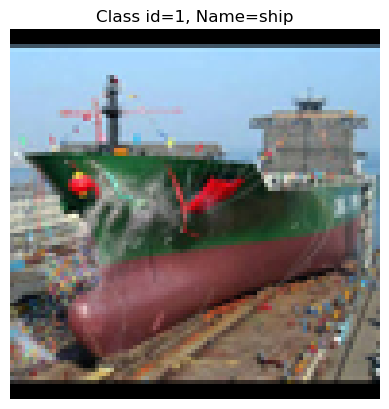

In [560]:
i = np.random.randint(0, train_two_classes_X.shape[0]-1)
visualize_sample(train_two_classes_X[i],
                 train_two_classes_y[i],
                 class_names_two_classes)

### 7. b) Load and augment the data for the 2 classes

In [ ]:
BATCH_SIZE = 32

train_ds = ArrayDataset(train_two_classes_X, train_two_classes_y, transform=train_transforms)
loader_two_classes_train = DataLoader(dataset = train_ds,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

test_ds = ArrayDataset(test_two_classes_X, test_two_classes_y, transform=None)
loader_two_classes_test = DataLoader(dataset = test_ds,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

cnn_two_classes = CNN(num_out_classes = 2, activation_function_type="relu").to(device)


### 7. c) Check accuracy for untrained model.

Probabilistically, training/testing accuracy should be 50% as images are categorised with no information as a coin flip.

In [594]:
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train',
                 print_output = True,
                 device = device)

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test',
                 print_output = True,
                 device = device)

Accuracy over "train" split is 50.0000%
Accuracy over "test" split is 50.0000%


50.0

### 7. d) Now train the CNN for 2 classes

Epoch 1/100 -> train loss 0.3514, test loss = 0.2449, train acc 90.4234, test acc = 91.0000
Epoch 2/100 -> train loss 0.2467, test loss = 0.2348, train acc 92.4395, test acc = 92.1875
Epoch 3/100 -> train loss 0.2191, test loss = 0.1791, train acc 93.7500, test acc = 93.1875
Epoch 4/100 -> train loss 0.1680, test loss = 0.1629, train acc 95.0605, test acc = 94.0000
Epoch 5/100 -> train loss 0.1435, test loss = 0.1615, train acc 96.7742, test acc = 93.8125
Epoch 6/100 -> train loss 0.1323, test loss = 0.1495, train acc 96.2702, test acc = 94.3125
Epoch 7/100 -> train loss 0.1019, test loss = 0.1375, train acc 97.4798, test acc = 95.1875
Epoch 8/100 -> train loss 0.0923, test loss = 0.1868, train acc 96.9758, test acc = 93.1875
Epoch 9/100 -> train loss 0.0977, test loss = 0.1538, train acc 96.5726, test acc = 94.3125
Epoch 10/100 -> train loss 0.0801, test loss = 0.1375, train acc 98.9919, test acc = 94.3750
Epoch 11/100 -> train loss 0.0763, test loss = 0.1706, train acc 97.2782, test 

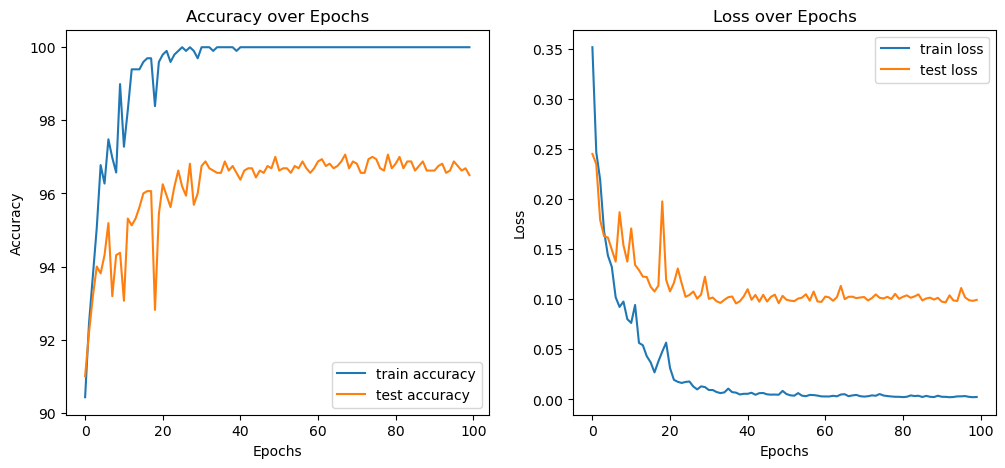

Finished Training


In [595]:
train(cnn = cnn_two_classes,
      loader_train = loader_two_classes_train,
      loader_test = loader_two_classes_test,
      num_epochs = 100,
      track_accuracy = True)

### 7. e) Compute accuracy of the model after traning

In [597]:
compute_accuracy(data_loader = loader_two_classes_train,
                 cnn = cnn_two_classes,
                 split = 'train',
                 print_output=True,
                 device=device)

compute_accuracy(data_loader = loader_two_classes_test,
                 cnn = cnn_two_classes,
                 split = 'test',
                 print_output=True,
                 device=device)

# torch.save(cnn_two_classes.state_dict(), '2class_relu_20epochs.pth')

Accuracy over "train" split is 100.0000%
Accuracy over "test" split is 96.5000%


96.5

# 8. Training and testing process for 10 class classification

### 8. a) Load and augment the data for the 10 classes

In [546]:
BATCH_SIZE = 64

train_ds_ten = ArrayDataset(full_train_X, full_train_y, transform=train_transforms)
loader_ten_classes_train = DataLoader(dataset = train_ds_ten,
                                      batch_size=BATCH_SIZE,
                                      shuffle=True,
                                      drop_last=True)

test_ds_ten = ArrayDataset(full_test_X, full_test_y, transform=None)
loader_ten_classes_test = DataLoader(dataset = test_ds_ten,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False)

cnn_ten_classes = CNN(num_out_classes = 10, activation_function_type="relu").to(device) 

### 8. b) Check accuracy for untrained model.

Probabilistically, training/testing accuracy should be 10% as images are categorised with no information by random chance. The probability of an image belonging to the correct category is around 10%.


In [547]:
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train',
                 print_output = True,
                 device = device)

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test',
                 print_output = True,
                 device = device)

Accuracy over "train" split is 10.1963%
Accuracy over "test" split is 10.0125%


10.012500000000001

### 8. c) Compute accuracy of the model after traning

Epoch 1/200 -> train loss 2.0113, test loss = 1.7021, train acc 39.6034, test acc = 38.7500
Epoch 2/200 -> train loss 1.7413, test loss = 1.5190, train acc 49.5793, test acc = 47.8250
Epoch 3/200 -> train loss 1.6353, test loss = 1.4355, train acc 51.8229, test acc = 50.1250
Epoch 4/200 -> train loss 1.5374, test loss = 1.3412, train acc 57.2316, test acc = 53.8500
Epoch 5/200 -> train loss 1.4815, test loss = 1.3014, train acc 58.7540, test acc = 54.5000
Epoch 6/200 -> train loss 1.4236, test loss = 1.2669, train acc 58.3534, test acc = 55.5625
Epoch 7/200 -> train loss 1.3873, test loss = 1.2368, train acc 60.1362, test acc = 56.1875
Epoch 8/200 -> train loss 1.3396, test loss = 1.1842, train acc 61.5986, test acc = 57.5625
Epoch 9/200 -> train loss 1.3006, test loss = 1.1944, train acc 62.3798, test acc = 58.3375
Epoch 10/200 -> train loss 1.2728, test loss = 1.1380, train acc 65.5649, test acc = 59.6875
Epoch 11/200 -> train loss 1.2476, test loss = 1.1143, train acc 66.5865, test 

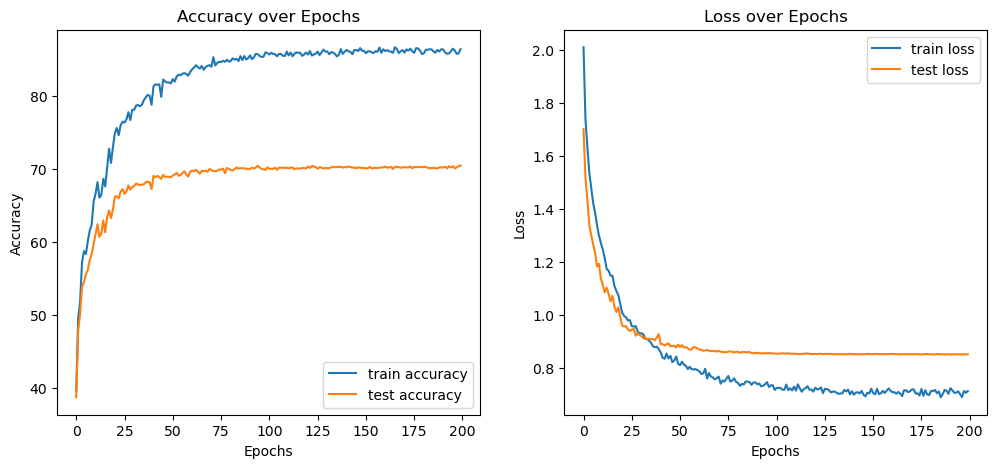

Finished Training


In [548]:
train(cnn = cnn_ten_classes,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 200,
      track_accuracy = True)

After training, computing accuracy for 10 class CNN model

In [549]:
compute_accuracy(data_loader = loader_ten_classes_train,
                 cnn = cnn_ten_classes,
                 split = 'train',
                 print_output = True,
                 device = device)

compute_accuracy(data_loader = loader_ten_classes_test,
                 cnn = cnn_ten_classes,
                 split = 'test',
                 print_output = True,
                 device = device)

Accuracy over "train" split is 86.4583%
Accuracy over "test" split is 70.4625%


70.46249999999999

# 9. Use the functions below to save and load the train models while retaining the trained weights.

Pytorch allows users to save their trained models, which retains the weights. These models can be investigated for further studied or even be trained further more more epochs.

In [ ]:
# torch.save(cnn_ten_classes.state_dict(), 'example.pth')

In [ ]:
gelu_100epochs = CNN(num_out_classes=10)
gelu_100epochs.load_state_dict(torch.load('example.pth', weights_only=True))

train(cnn = gelu_100epochs,
      loader_train = loader_ten_classes_train,
      loader_test = loader_ten_classes_test,
      num_epochs = 100,
      track_accuracy = True)

# 10. References